In [1]:
from gorgo import infer, condition, draw_from, flip, keep_deterministic, mem
from gorgo.hashable import hashabledict
from gorgo.distributions.builtin_dists import Uniform, Beta

from model import Utterance, Instance, Kind, meaning, literal_listener, speaker, pragmatic_listener

import numpy as np
from gorgo.inference import MaximumMarginalAPosteriori
import pickle

from collections import namedtuple
import math
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter

from scipy.stats import pearsonr


In [229]:
# helper functions
## convert gorgo dist to df for plotting
@keep_deterministic
def dist_to_df(dist):
    df_dist = pd.DataFrame()
    if isinstance(dist.support[0], float): 
        df_dist['Element'] = pd.DataFrame(dist.support)
    else: # df can't support multiple keys
        df_dist = pd.DataFrame(dist.support)
    df_dist['Probability'] = dist.probabilities
    return df_dist

# Modeling inferences about category coherence from generics

* **listener**: considering only the *features observed so far*
* **speaker**: trying to communicate which *of the features observed* is kind-linked

## Literal listener

**Meaning function**

* Features are either kind-linked or not kind-linked. 
* A *generic statement* is true if the mentioned feature $f$ is in the set of features true of the category (i.e., the property is kind-linked).
* A *specific statement* is true if the mentioned feature $f$ is in the set of features true of the individual. 
* eq. 1:

$$[[u_i]](\mathcal{F}_k, x_i) = 
\begin{cases}
1[f \in \mathcal{F}_k] \text{, if } u_i = \text{"$k$s are $f$"}\\
1[f \in x_i] \text{, if } u_i = \text{"This $k$ is $f$"}\\
0 \text{, otherwise}
\end{cases}$$

**Literal listener** is simultaneously inferring $\mathcal{F}_k$ (set of kind-linked features, **out of the features of observed individuals**) and $\theta$ (category coherence) from the literal meaning of the speaker's utterances $u$ about observed instance $x$ (eq. 2):

$$\text{Lit}(\mathcal{F}_k, \theta | x, u) \propto P(\theta)P(\mathcal{F}_k|\theta)\prod_{i}[[u_i]](\mathcal{F}_k, x_i)$$

* $\mathcal{F}_k$ = set of **kind-linked features**, a subset of features observed so far
* $\theta =P(f \in \mathcal{F}_k)$ = **category coherence** of kind = likelihood that any feature will be kind-linked
* $x$, $u$ = set of pairs of **observed instances and utterances**

<!-- -->

* $P(\theta)$ = **prior on coherence**
* $P(\mathcal{F}_k|\theta)$ = $\prod_{f_i \in \mathcal{F}}P(f_i \in \mathcal{F}_k | \theta)$ = **kind feature likelihood** = likelihood of a given set of kind-linked features $\mathcal{F}_k$ given the coherence $\theta$
* $\prod_{i}[[u_i]](\mathcal{F}_k, x_i)$ = **meaning** of utterance given instance, via meaning function, for all utterance-instance pairs in data


### Model predictions

#### Hearing a generic

hearing "Zarpies eat flowers" about a Zarpie that eats flowers

In [2]:
# set up data
data = (
    (Utterance(subj='Zarpies', feature='eats flowers'), 
     Instance(kind='Zarpie', features=('eats flowers', ))),
)

In [3]:
# run literal listener
dist = literal_listener(data)

# convert inferred set of zarpie features & coherence to df
df = dist_to_df(dist)

NameError: name 'dist_to_df' is not defined

In [234]:
# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

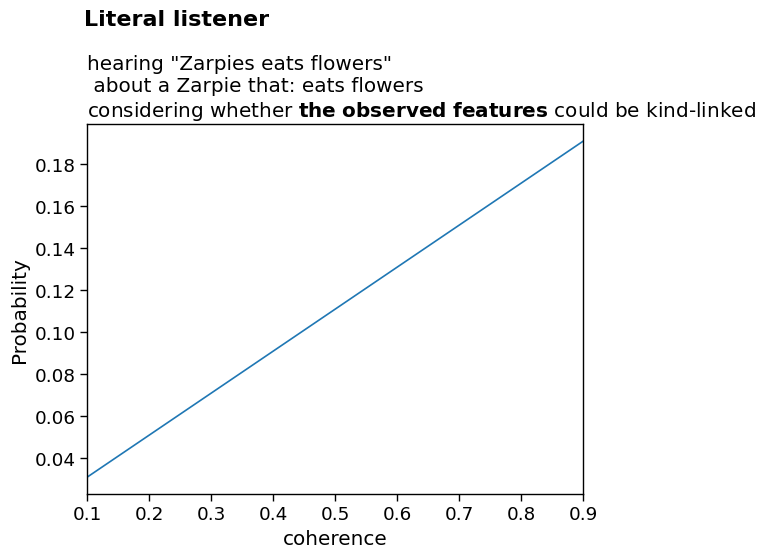

In [235]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Literal listener",
             x = 0.12, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs/literal_listener_generic_1_coherence.png", bbox_inches = "tight")
plt.show(g)

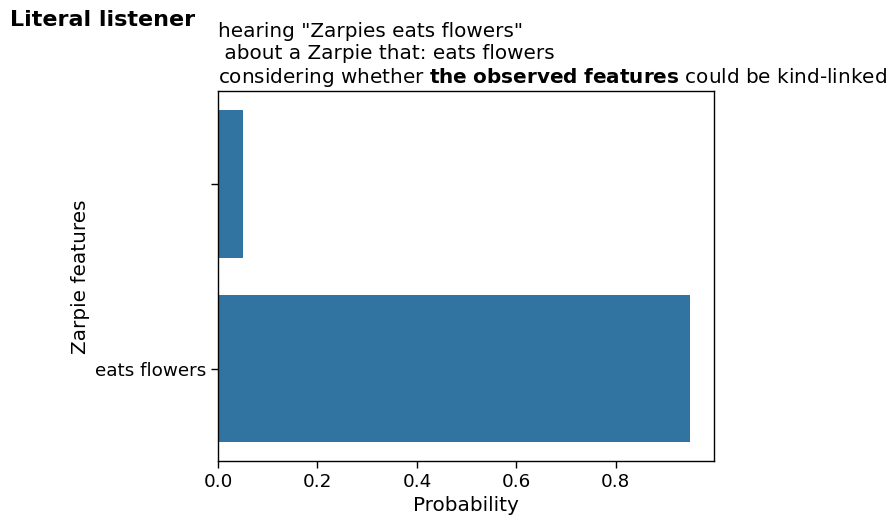

In [236]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Literal listener",
             x = -0.2, y = 1.05,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs/literal_listener_generic_1_features.png", bbox_inches = "tight")
plt.show(g)

hearing "Zarpies eat flowers" about a Zarpie that eats flowers and sings lovely songs

In [237]:
# set up data
data = (
    (Utterance(subj='Zarpies', feature='eats flowers'), 
     Instance(kind='Zarpie', features=('eats flowers', 'scared of shadows'))),
)

# run literal listener
dist = literal_listener(data)

# convert to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')


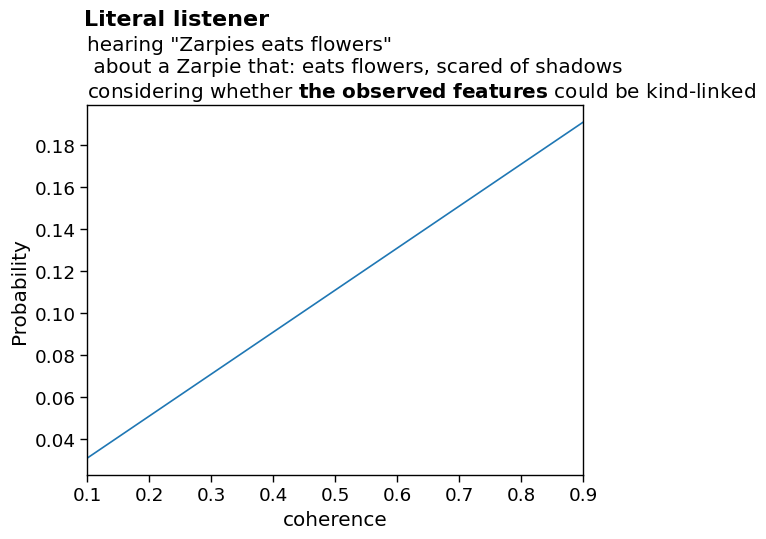

In [238]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Literal listener",
             x = 0.12, y = 1 + 0.08*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs/literal_listener_generic_2_coherence.png", bbox_inches = "tight")
plt.show(g)

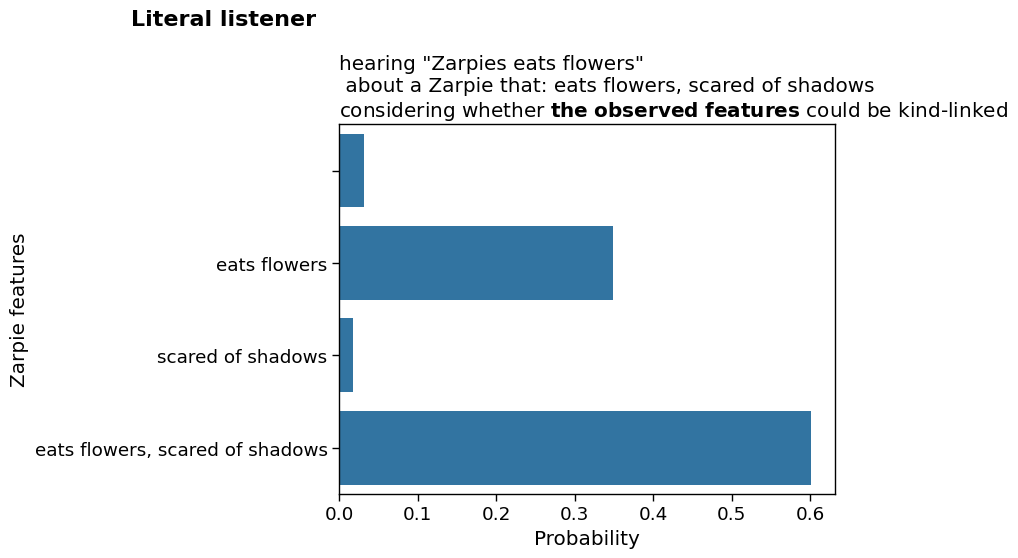

In [239]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Literal listener",
             x = -0.2, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs/literal_listener_generic_2_features.png", bbox_inches = "tight")
plt.show(g)

#### Hearing a specific

* specifics are treated as irrelevant to coherence, and to kind status of the mentioned feature or unmentioned features

In [240]:
# set up data
data = (
    (Utterance(subj='This Zarpie', feature='eats flowers'), Instance(kind='Zarpie', features=('eats flowers',))) ,
    )

# run literal listener
dist = literal_listener(data)

# convert to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

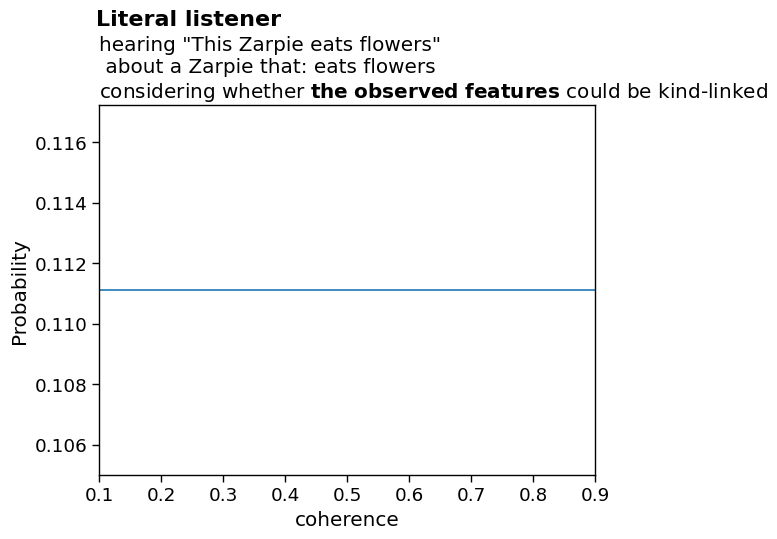

In [241]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Literal listener",
             x = 0.12, y = 1 + 0.08*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs/literal_listener_specific_1_coherence.png", bbox_inches = "tight")
plt.show(g)

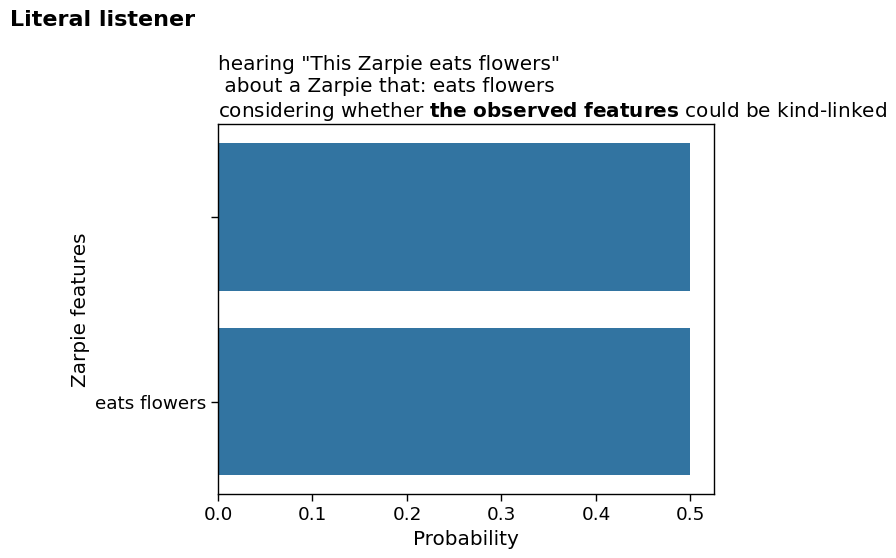

In [242]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Literal listener",
             x = -0.2, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs/literal_listener_specific_1_features.png", bbox_inches = "tight")
plt.show(g)

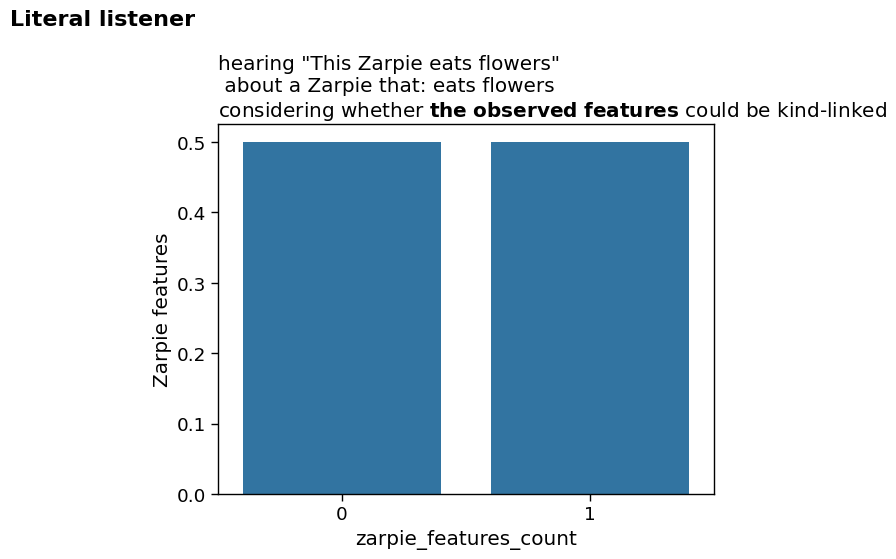

In [243]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features.groupby("zarpie_features_count").aggregate("sum").reset_index(),
                 x = "zarpie_features_count",
                 y = "Probability")
plt.ylabel("Zarpie features")
plt.suptitle("Literal listener",
             x = -0.2, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs/literal_listener_specific_1_featurescount.png", bbox_inches = "tight")
plt.show(g)

#### Hearing multiple trials

In [244]:
# set up trials
data = (
    (Utterance("Zarpies", "eats flowers"), Instance("Zarpie", ("eats flowers",))),
    (Utterance("This Zarpie", "scared of shadows"), Instance("Zarpie", ("scared of shadows",)))
)

In [245]:
# run pragmatic listener
dist = literal_listener(data)

# convert to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

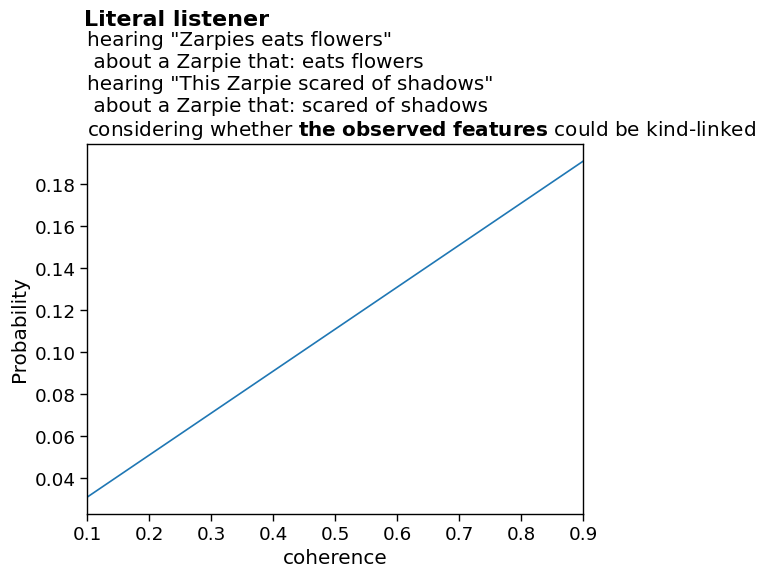

In [246]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Literal listener",
             x = 0.12, y = 1 + 0.08*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs/literal_listener_multiple_1_coherence.png", bbox_inches = "tight")
plt.show(g)

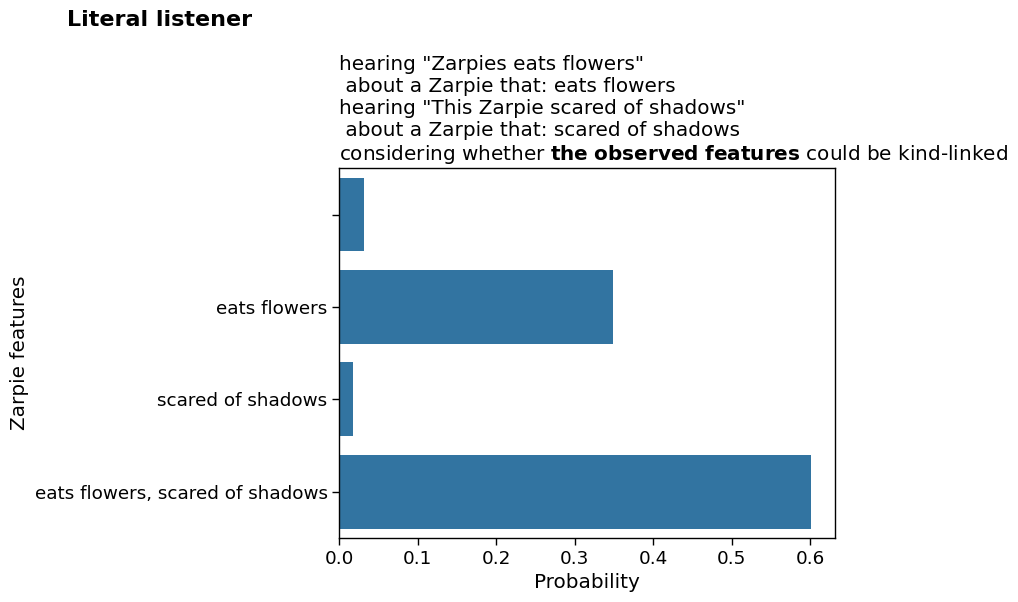

In [247]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Literal listener",
             x = -0.3, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs/literal_listener_multiple_1_features.png", bbox_inches = "tight")
plt.show(g)

## Speaker

* **Jaccard similarity**: ranges between 0 and 1 for two sets $A$ and $B$ (footnote 1):

$$\text{Similarity}(A, B) = \frac{|A \cap B|}{|A \cup B|}$$

* **utility function**: speaker is trying to align what their listener infers about the observed features of the individual $\mathcal{F}_k$ with the true kind-linked status of those features $\mathcal{F}_k^*$ (eq. 4, the note below eq. 4):
    * First term - literal listener's posterior probability of kind-linked features, out of the individual's features
    * Second term - similarity between that set of features and the true kind-linked status of those features
    * Multiplying them for each Fk, and then summing over all Fks in the distribution, gives you the expected utility

$$\text{Utility}(u_i, x_i, \mathcal{F}_k^*) = \sum_{\mathcal{F}_k} \text{Lit}(\mathcal{F}_k|x_i, u_i) \cdot \text{Similarity}(\mathcal{F}_k^* \cup x_i, \mathcal{F}_k \cup x_i)$$

$$\text{Lit}(\mathcal{F}_k|x_i, u_i) = \int \text{Lit}(\mathcal{F}_k, \theta | x_i, u_i)d\theta$$



* **speaker**: speaker is trying to maximize utility with some rationality/inverse temp $\beta$ (eq. 5):

$$\text{Speaker}(u_i|\mathcal{F}_k^*, x_i) \propto \text{exp}(\beta \cdot \text{Utility}(u_i, x_i, \mathcal{F}_k^*))$$

### Model predictions

In [251]:
# set up kind-linked features
zarpies = Kind("Zarpies", ("eats flowers", "sings lovely songs", "jumps over puddles")) # Zarpies have these kind-linked features

# set up instance in data
example_zarpie = Instance("Zarpies", ("eats flowers", ))    # observe an instance of Zarpie that has these features

# run speaker model
dist = speaker(kind_features = zarpies.features, 
               observed_instance = example_zarpie)

dist

subj,feature,Probability
Zarpies,eats flowers,1.000
This Zarpie,eats flowers,1.23e-04
silence,eats flowers,1.23e-04


In [252]:
# FIXME
# dist.marginalize(lambda x: Utterance(subj='Zarpies', feature='eats flowers') in x['Utterance'])
# dist.marginalize(lambda x: len(x['zarpie_features']))
# dist.marginalize(lambda x: x['coherence'])
# dist.marginalize(lambda x: "scared of shadows" in x['zarpie_features'])
# dist.marginalize(lambda x: "sings lovely songs" in x['zarpie_features']).prob(True)

In [253]:
dist.support

(Utterance(subj='Zarpies', feature='eats flowers'),
 Utterance(subj='This Zarpie', feature='eats flowers'),
 Utterance(subj='silence', feature='eats flowers'))

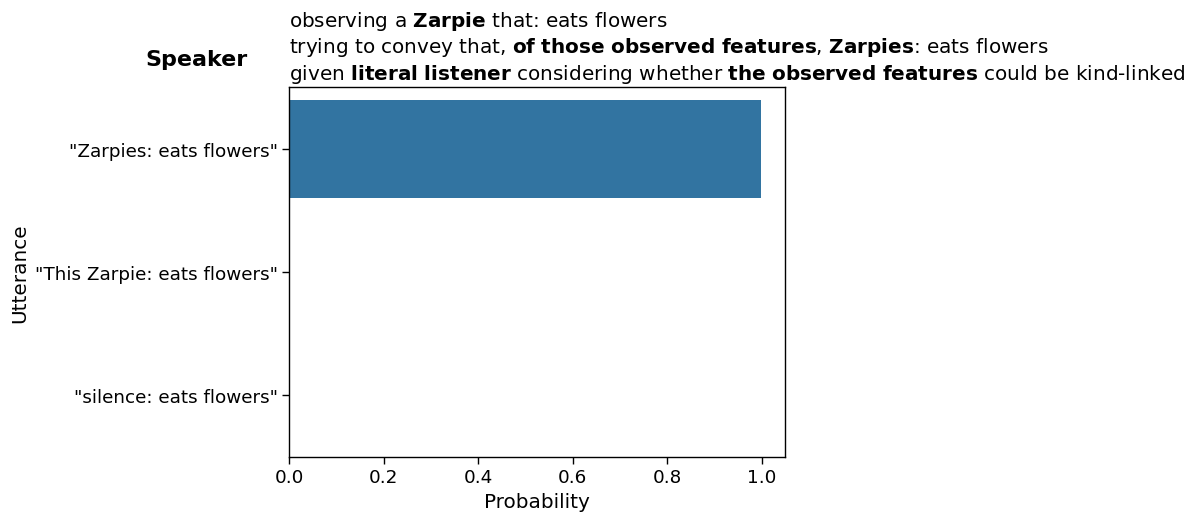

In [254]:
# convert to df
df_dist = dist_to_df(dist)
df_dist['Utterance'] = "\"" + df_dist['subj'] + ": " + df_dist['feature'] + "\""

# plot
g = sns.barplot(data = df_dist,
                 x = "Probability",
                 y = "Utterance")
plt.suptitle("Speaker",
             x = -0.1, y = 0.96,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title(r"observing a $\bf{Zarpie}$ that: " +
             ", ".join(example_zarpie.features) + "\n" +
             r"trying to convey that, $\bf{of}$ $\bf{those}$ $\bf{observed}$ $\bf{features}$, $\bf{Zarpies}$: " + 
             ", ".join(set(example_zarpie.features) & set(zarpies.features)) + "\n" +
             r"given $\bf{literal}$ $\bf{listener}$ considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
             x = 0, y = 1,
             horizontalalignment = "left")

plt.savefig("figs/speaker_kindlinked.png", bbox_inches = "tight")
plt.show(g)

#### No generic exaggeration effect

* **Generic exaggeration effect** - speaker more likely to say a generic about a feature true of individual but not true of kind, over a specific, to get listener to believe the kind does share other features that it does in fact share

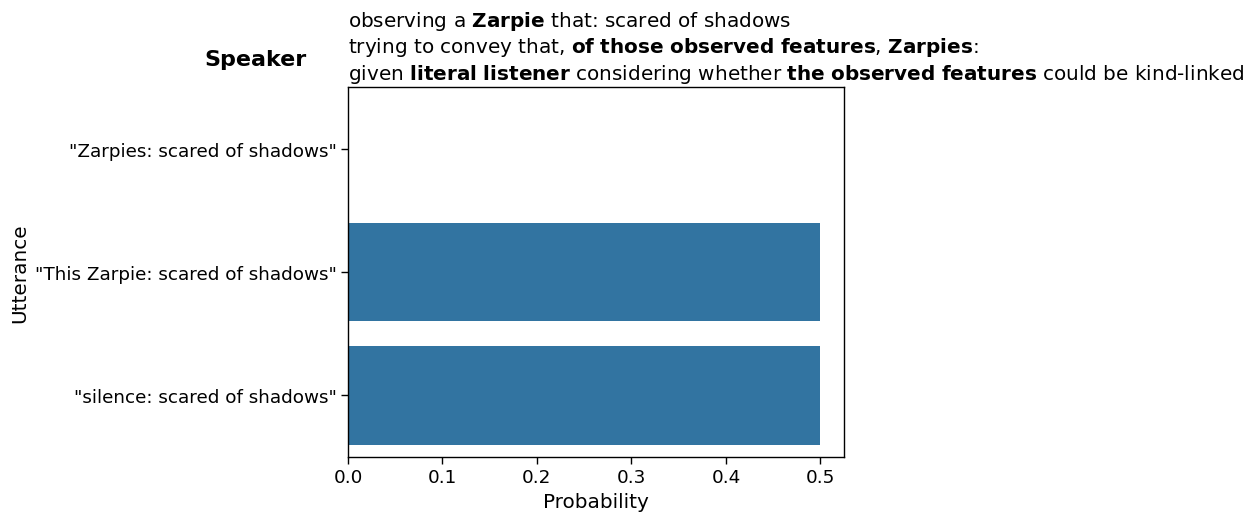

In [255]:
# set up data
zarpies = Kind("Zarpies", ("eats flowers", "sings lovely songs", "jumps over puddles")) # Zarpies have these kind-linked features
example_zarpie = Instance("Zarpies", ("scared of shadows", ))    # observe an instance of Zarpie that has these features

# run speaker model
dist = speaker(kind_features = zarpies.features, 
               observed_instance = example_zarpie)

# convert to df
df_dist = dist_to_df(dist)
df_dist['Utterance'] = "\"" + df_dist['subj'] + ": " + df_dist['feature'] + "\""

# plot
g = sns.barplot(data = df_dist,
                 x = "Probability",
                 y = "Utterance")
plt.suptitle("Speaker",
             x = -0.1, y = 0.96,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title(r"observing a $\bf{Zarpie}$ that: " +
             ", ".join(example_zarpie.features) + "\n" +
             r"trying to convey that, $\bf{of}$ $\bf{those}$ $\bf{observed}$ $\bf{features}$, $\bf{Zarpies}$: " + 
             ", ".join(set(example_zarpie.features) & set(zarpies.features)) + "\n" +
             r"given $\bf{literal}$ $\bf{listener}$ considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
             x = 0, y = 1,
             horizontalalignment = "left")

plt.savefig("figs/speaker_1idiosyncratic.png", bbox_inches = "tight")
plt.show(g)

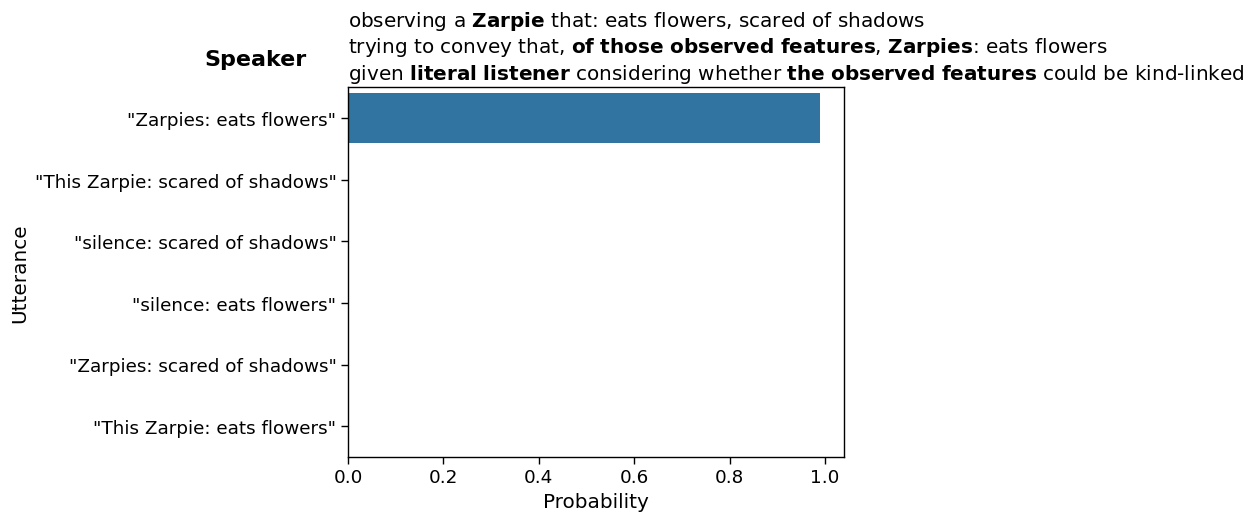

In [256]:
# set up data
zarpies = Kind("Zarpies", ("eats flowers", "sings lovely songs", "jumps over puddles")) # Zarpies have these kind-linked features
example_zarpie = Instance("Zarpies", ("eats flowers", "scared of shadows"))             # observe an instance of Zarpie that has these features

# run speaker model
dist = speaker(kind_features = zarpies.features, 
               observed_instance = example_zarpie)

# convert to df
df_dist = dist_to_df(dist)
df_dist['Utterance'] = "\"" + df_dist['subj'] + ": " + df_dist['feature'] + "\""

# plot
g = sns.barplot(data = df_dist,
                 x = "Probability",
                 y = "Utterance")
plt.suptitle("Speaker",
             x = -0.1, y = 0.96,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title(r"observing a $\bf{Zarpie}$ that: " +
             ", ".join(example_zarpie.features) + "\n" +
             r"trying to convey that, $\bf{of}$ $\bf{those}$ $\bf{observed}$ $\bf{features}$, $\bf{Zarpies}$: " + 
             ", ".join(set(example_zarpie.features) & set(zarpies.features)) + "\n" +
             r"given $\bf{literal}$ $\bf{listener}$ considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
             x = 0, y = 1,
             horizontalalignment = "left")

plt.savefig("figs/speaker_1kindlinked_1idiosyncratic.png", bbox_inches = "tight")
plt.show(g)

## Pragmatic listener

Pragmatic listener is reasoning, not about literal truth-value of utterances, but about likelihood that a speaker reasoning about a literal listener will produce the utterance. 

Replace the literal semantics likelihood in Equation 2 with the speaker likelihood (Equation 5) to make eq. 6:

$$\text{Prag}(\mathcal{F}_k, \theta | x, u) \propto P(\theta)P(\mathcal{F}_k|\theta)\prod_{i}\text{Sp}(u_i|\mathcal{F}_k, x_i)$$

### Model predictions

#### Hearing a generic

In [259]:
# set up data
data = (
    (Utterance(subj='Zarpies', feature='eats flowers'), Instance(kind='Zarpie', features=('eats flowers', ))),
)

In [260]:
# run pragmatic_listener
dist = pragmatic_listener(data)

# convert inferred set of zarpie features & coherence to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

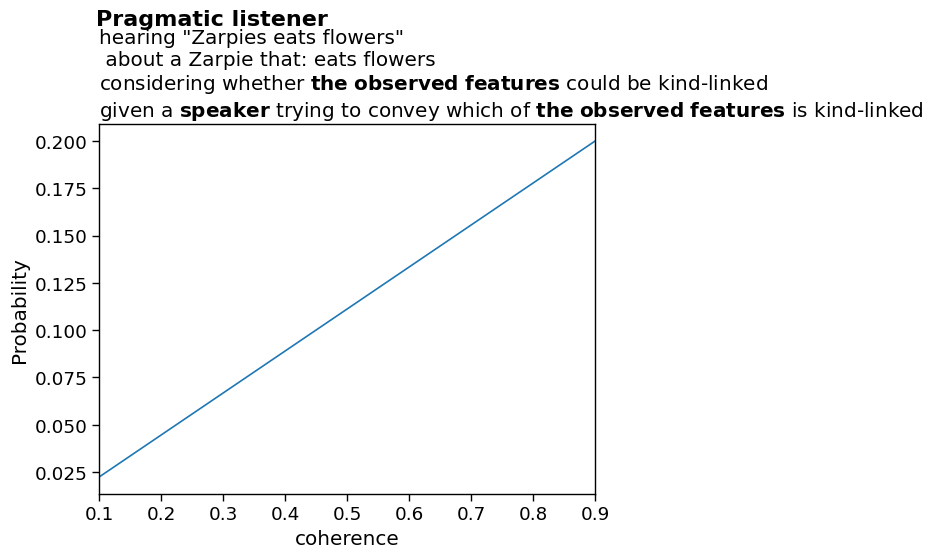

In [261]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Pragmatic listener",
             x = 0.12, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs/pragmatic_listener_generic_1_coherence.png", bbox_inches = "tight")
plt.show(g)

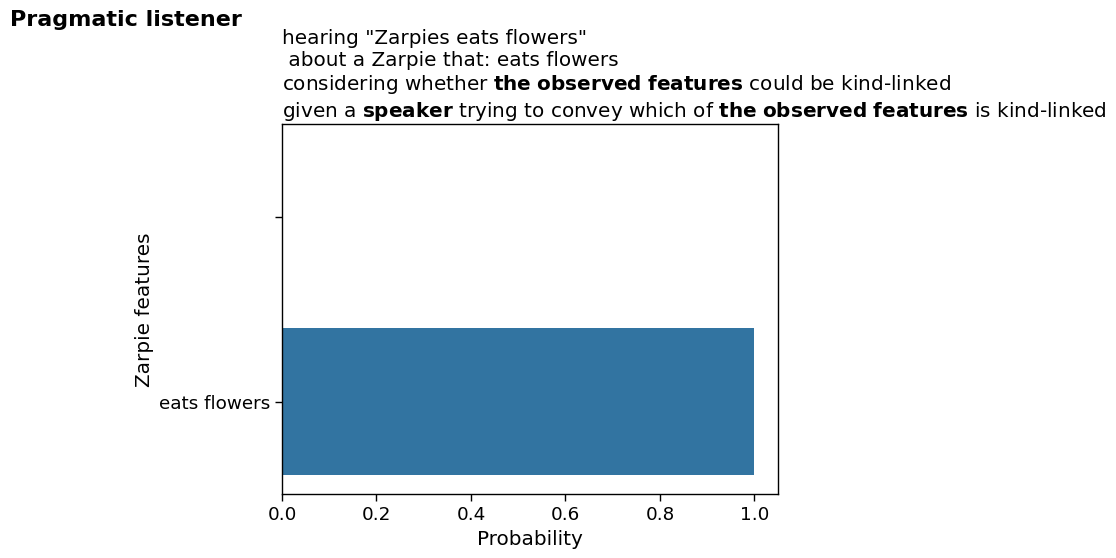

In [262]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Pragmatic listener",
             x = -0.3, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs/pragmatic_listener_generic_1_features.png", bbox_inches = "tight")
plt.show(g)

In [263]:
# set up data
data = (
    (Utterance(subj='Zarpies', feature='eats flowers'), 
     Instance(kind='Zarpie', features=('eats flowers', 'scared of shadows'))),
)

In [264]:
# run pragmatic_listener
dist = pragmatic_listener(data)

# convert to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

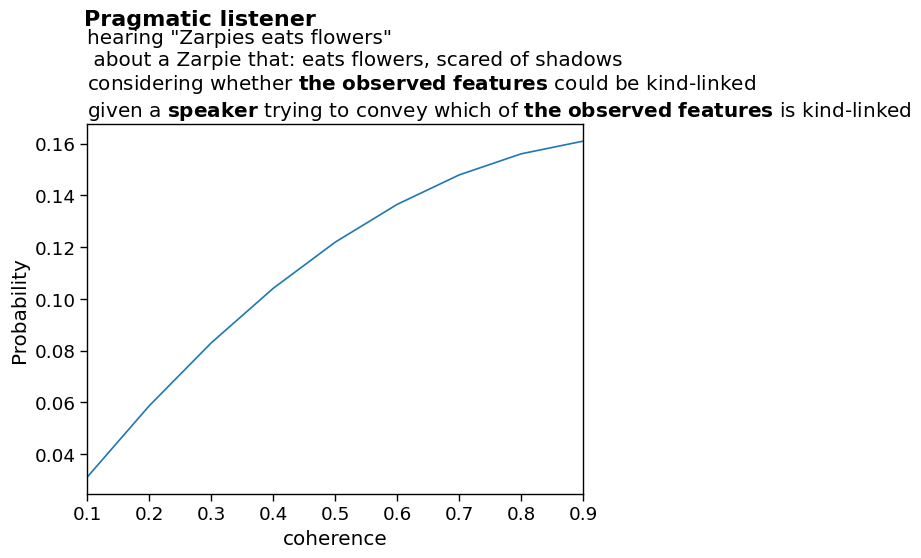

In [265]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Pragmatic listener",
             x = 0.12, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs/pragmatic_listener_generic_2_coherence.png", bbox_inches = "tight")
plt.show(g)

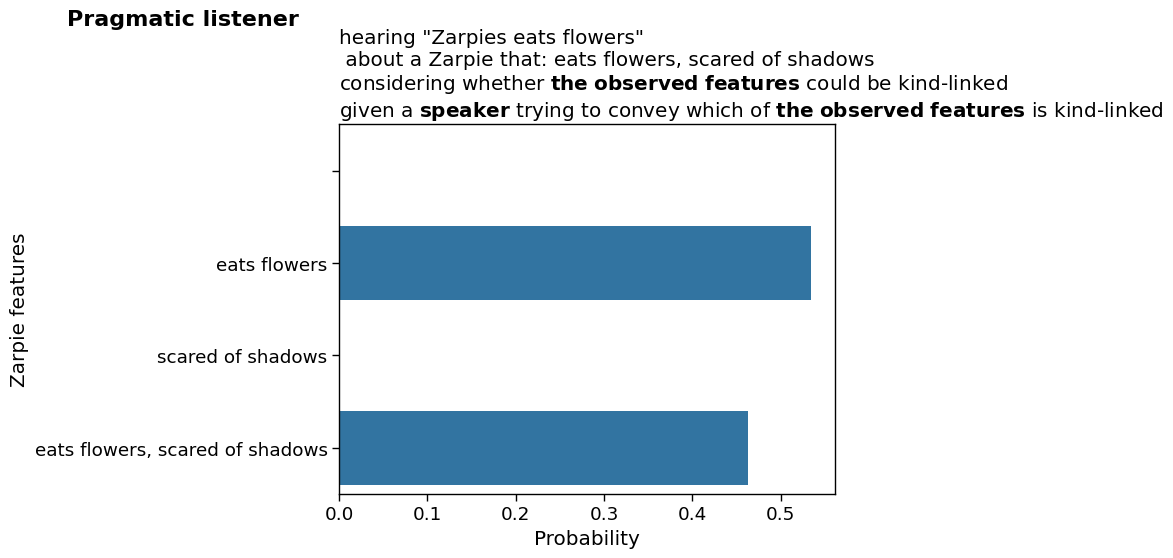

In [266]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Pragmatic listener",
             x = -0.3, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs/pragmatic_listener_generic_2_features.png", bbox_inches = "tight")
plt.show(g)

#### Hearing a specific

In [267]:
# set up trial
data = (
    (Utterance(subj='This Zarpie', feature='eats flowers'), 
     Instance(kind='Zarpie', features=('eats flowers', ))) ,
)

# run pragmatic listener
dist = pragmatic_listener(data)

# convert to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

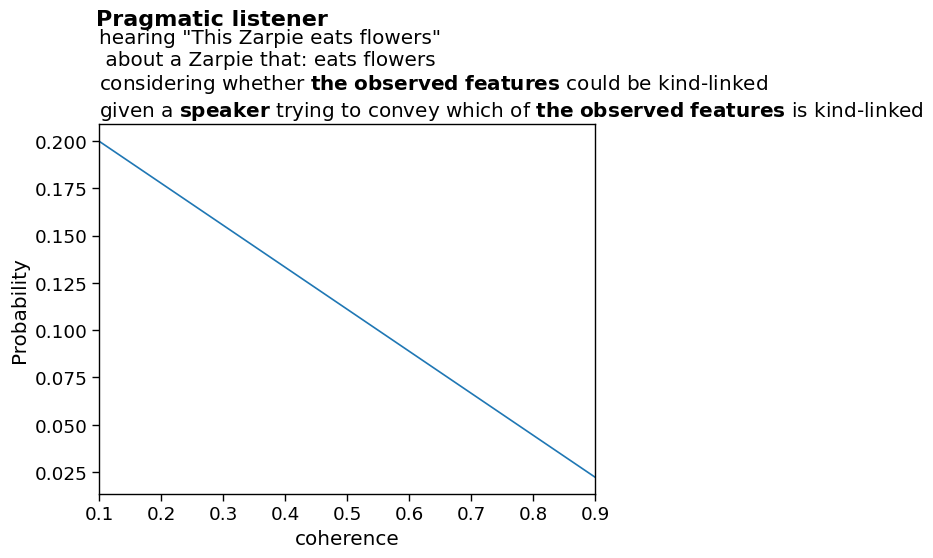

In [268]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Pragmatic listener",
             x = 0.12, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs/pragmatic_listener_specific_1_coherence.png", bbox_inches = "tight")
plt.show(g)

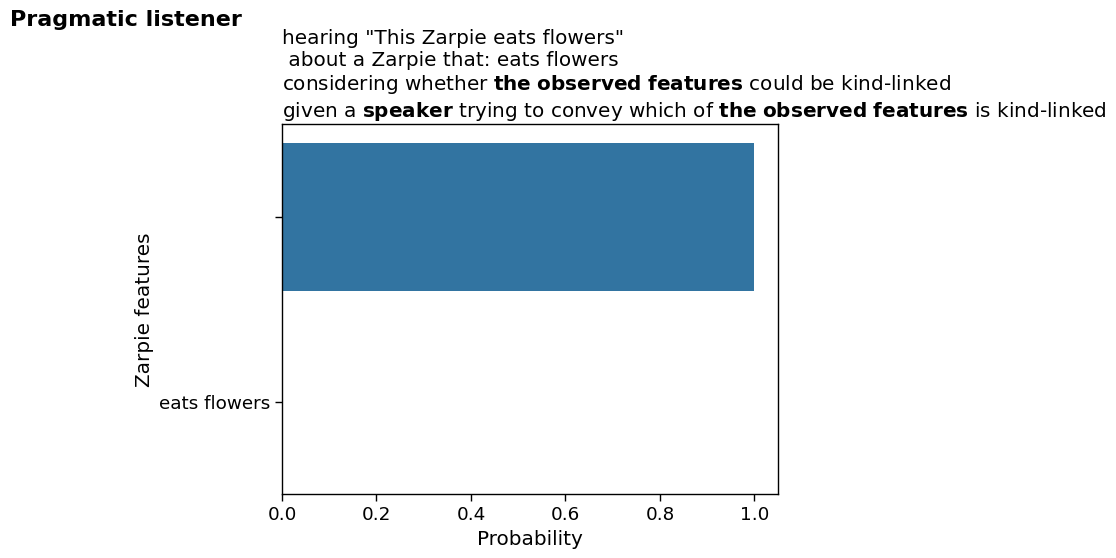

In [269]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Pragmatic listener",
             x = -0.3, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs/pragmatic_listener_specific_1_features.png", bbox_inches = "tight")
plt.show(g)

In [270]:
# set up trial
data = (
    (Utterance(subj='This Zarpie', feature='eats flowers'), 
     Instance(kind='Zarpie', features=('eats flowers', 'scared of shadows'))) ,
)

# run pragmatic listener
dist = pragmatic_listener(data)

# convert to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

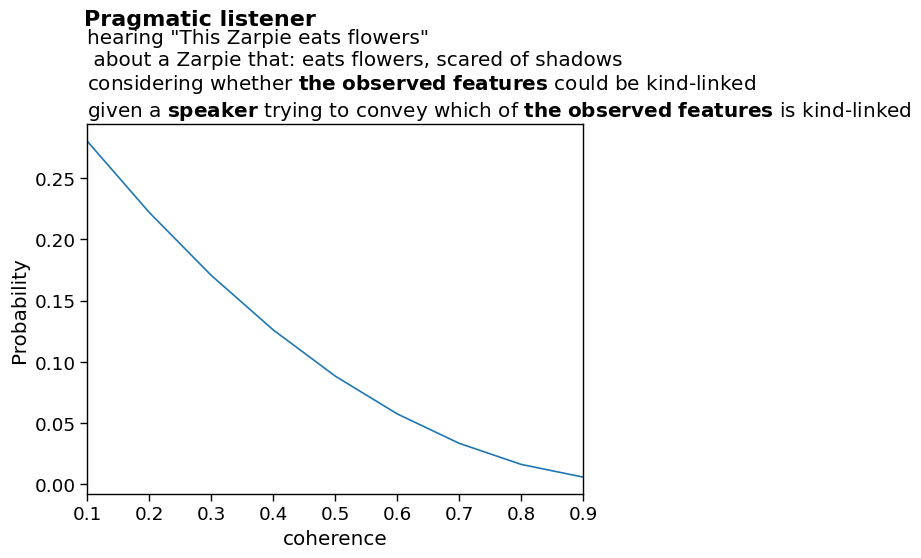

In [271]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Pragmatic listener",
             x = 0.12, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs/pragmatic_listener_specific_2_coherence.png", bbox_inches = "tight")
plt.show(g)

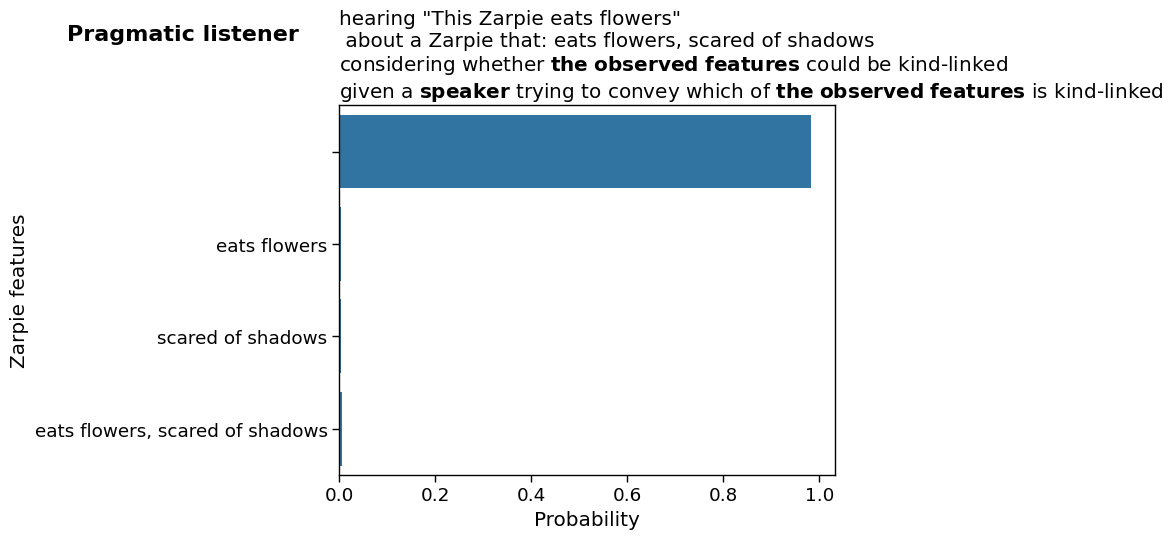

In [272]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Pragmatic listener",
             x = -0.3, y = 1.05,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs/pragmatic_listener_specific_2_features.png", bbox_inches = "tight")
plt.show(g)

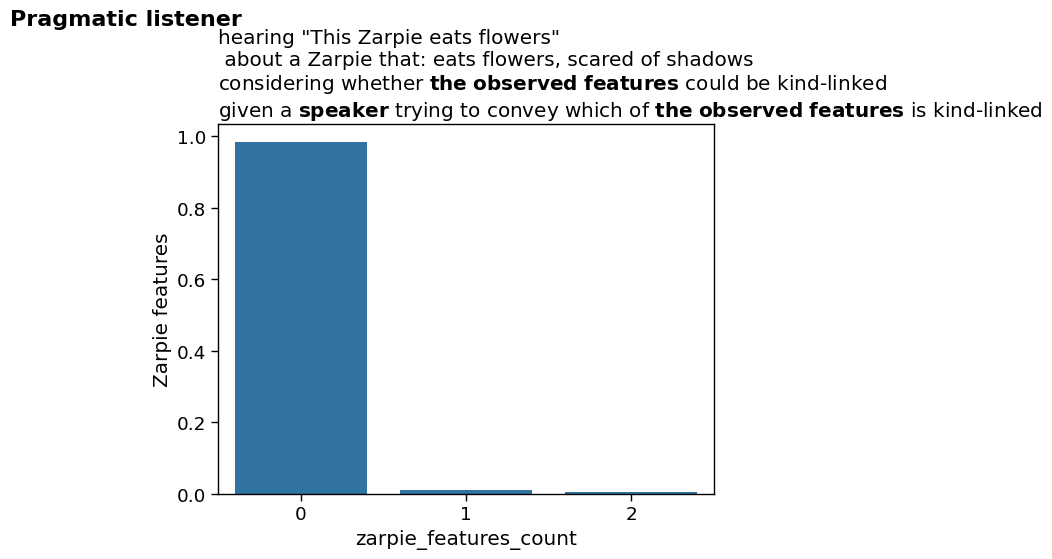

In [273]:
# plot number of inferred features
g = sns.barplot(data = df_zarpie_features.groupby("zarpie_features_count").aggregate("sum").reset_index(),
                 x = "zarpie_features_count",
                 y = "Probability")
plt.ylabel("Zarpie features")
plt.suptitle("Pragmatic listener",
             x = -0.2, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs/pragmatic_listener_specific_2_featurescount.png", bbox_inches = "tight")
plt.show(g)

#### Hearing multiple trials

In [274]:
# set up trials
data = (
    (Utterance("Zarpies", "eats flowers"), Instance("Zarpie", ("eats flowers", ))),
    (Utterance("This Zarpie", "scared of shadows"), Instance("Zarpie", ("scared of shadows", )))
)

In [275]:
# run pragmatic listener
dist = pragmatic_listener(data)

# convert to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

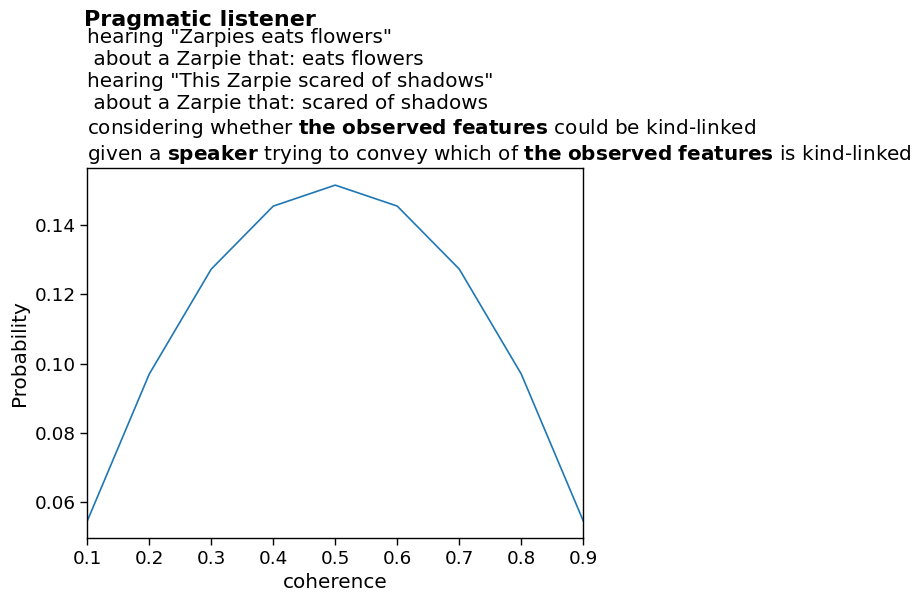

In [276]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Pragmatic listener",
             x = 0.12, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs/pragmatic_listener_multiple_1_coherence.png", bbox_inches = "tight")
plt.show(g)

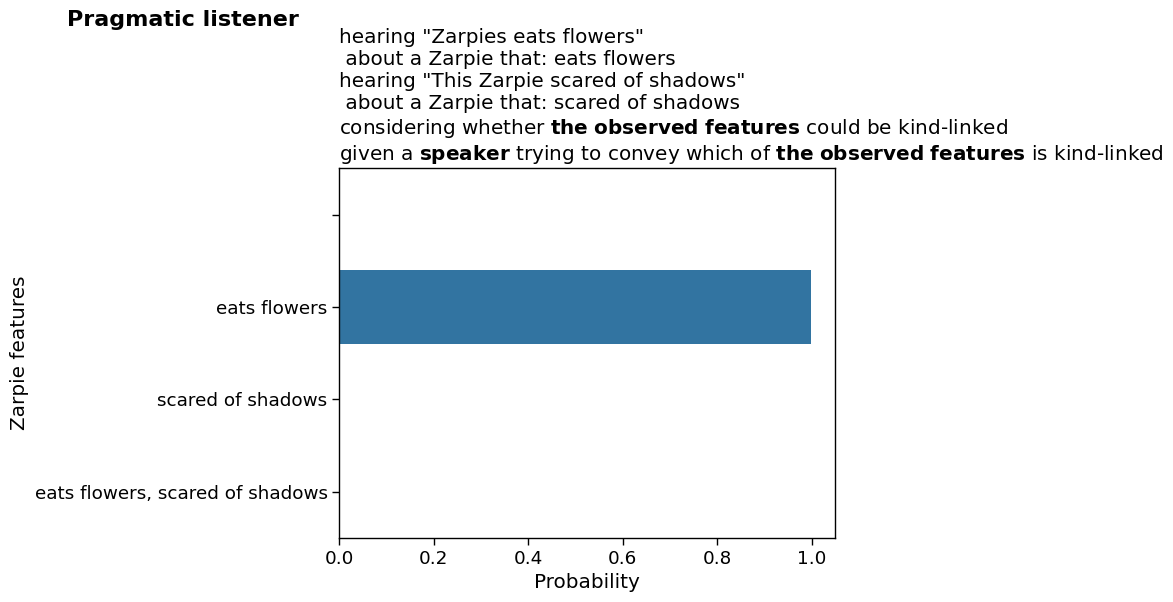

In [277]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Pragmatic listener",
             x = -0.3, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs/pragmatic_listener_multiple_1_features.png", bbox_inches = "tight")
plt.show(g)

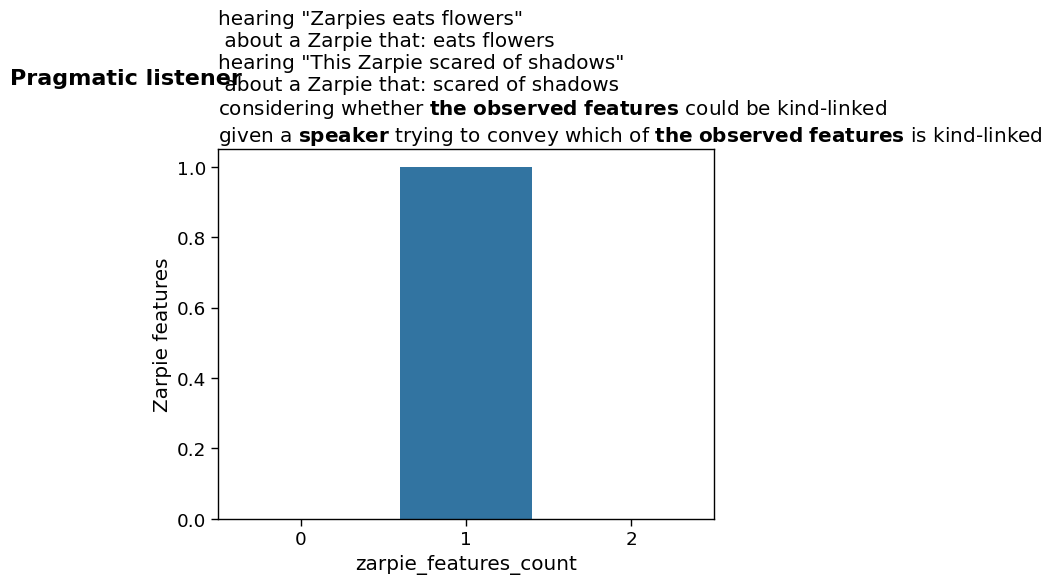

In [278]:
# plot number of inferred features
g = sns.barplot(data = df_zarpie_features.groupby("zarpie_features_count").aggregate("sum").reset_index(),
                 x = "zarpie_features_count",
                 y = "Probability")
plt.ylabel("Zarpie features")
plt.suptitle("Pragmatic listener",
             x = -0.2, y = 1.05,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs/pragmatic_listener_multiple_1_featurescount.png", bbox_inches = "tight")
plt.show(g)

In [279]:
# set up trials
data = (
    (Utterance("Zarpies", "eats flowers"), Instance("Zarpie", ("eats flowers", ))),
    (Utterance("This Zarpie", "scared of shadows"), Instance("Zarpie", ("scared of shadows", ))),
    (Utterance("This Zarpie", "jumps over puddles"), Instance("Zarpie", ("jumps over puddles", "sings lovely songs")))
)

In [280]:
# run pragmatic listener
dist = pragmatic_listener(data)

dist

DiscreteInferenceResult(support=({'zarpie_features': ('eats flowers',), 'coherence': 0.1}, {'zarpie_features': ('eats flowers', 'sings lovely songs'), 'coherence': 0.1}, {'zarpie_features': ('eats flowers', 'jumps over puddles'), 'coherence': 0.1}, {'zarpie_features': ('eats flowers', 'sings lovely songs', 'jumps over puddles'), 'coherence': 0.1}, {'zarpie_features': ('eats flowers', 'scared of shadows'), 'coherence': 0.1}, {'zarpie_features': ('eats flowers', 'sings lovely songs', 'scared of shadows'), 'coherence': 0.1}, {'zarpie_features': ('eats flowers', 'scared of shadows', 'jumps over puddles'), 'coherence': 0.1}, {'zarpie_features': ('eats flowers', 'sings lovely songs', 'scared of shadows', 'jumps over puddles'), 'coherence': 0.1}, {'zarpie_features': (), 'coherence': 0.1}, {'zarpie_features': ('sings lovely songs',), 'coherence': 0.1}, {'zarpie_features': ('jumps over puddles',), 'coherence': 0.1}, {'zarpie_features': ('sings lovely songs', 'jumps over puddles'), 'coherence': 0.1}, {'zarpie_features': ('scared of shadows',), 'coherence': 0.1}, {'zarpie_features': ('sings lovely songs', 'scared of shadows'), 'coherence': 0.1}, {'zarpie_features': ('scared of shadows', 'jumps over puddles'), 'coherence': 0.1}, {'zarpie_features': ('sings lovely songs', 'scared of shadows', 'jumps over puddles'), 'coherence': 0.1}, {'zarpie_features': ('eats flowers',), 'coherence': 0.3}, {'zarpie_features': ('eats flowers', 'sings lovely songs'), 'coherence': 0.3}, {'zarpie_features': ('eats flowers', 'jumps over puddles'), 'coherence': 0.3}, {'zarpie_features': ('eats flowers', 'sings lovely songs', 'jumps over puddles'), 'coherence': 0.3}, {'zarpie_features': ('eats flowers', 'scared of shadows'), 'coherence': 0.3}, {'zarpie_features': ('eats flowers', 'sings lovely songs', 'scared of shadows'), 'coherence': 0.3}, {'zarpie_features': ('eats flowers', 'scared of shadows', 'jumps over puddles'), 'coherence': 0.3}, {'zarpie_features': ('eats flowers', 'sings lovely songs', 'scared of shadows', 'jumps over puddles'), 'coherence': 0.3}, {'zarpie_features': (), 'coherence': 0.3}, {'zarpie_features': ('sings lovely songs',), 'coherence': 0.3}, {'zarpie_features': ('jumps over puddles',), 'coherence': 0.3}, {'zarpie_features': ('sings lovely songs', 'jumps over puddles'), 'coherence': 0.3}, {'zarpie_features': ('scared of shadows',), 'coherence': 0.3}, {'zarpie_features': ('sings lovely songs', 'scared of shadows'), 'coherence': 0.3}, {'zarpie_features': ('scared of shadows', 'jumps over puddles'), 'coherence': 0.3}, {'zarpie_features': ('sings lovely songs', 'scared of shadows', 'jumps over puddles'), 'coherence': 0.3}, {'zarpie_features': ('eats flowers',), 'coherence': 0.7}, {'zarpie_features': ('eats flowers', 'sings lovely songs', 'jumps over puddles'), 'coherence': 0.7}, {'zarpie_features': ('eats flowers', 'jumps over puddles'), 'coherence': 0.7}, {'zarpie_features': ('eats flowers', 'sings lovely songs'), 'coherence': 0.7}, {'zarpie_features': ('eats flowers', 'scared of shadows'), 'coherence': 0.7}, {'zarpie_features': ('eats flowers', 'sings lovely songs', 'scared of shadows', 'jumps over puddles'), 'coherence': 0.7}, {'zarpie_features': ('eats flowers', 'scared of shadows', 'jumps over puddles'), 'coherence': 0.7}, {'zarpie_features': ('eats flowers', 'sings lovely songs', 'scared of shadows'), 'coherence': 0.7}, {'zarpie_features': (), 'coherence': 0.7}, {'zarpie_features': ('sings lovely songs', 'jumps over puddles'), 'coherence': 0.7}, {'zarpie_features': ('jumps over puddles',), 'coherence': 0.7}, {'zarpie_features': ('sings lovely songs',), 'coherence': 0.7}, {'zarpie_features': ('scared of shadows',), 'coherence': 0.7}, {'zarpie_features': ('sings lovely songs', 'scared of shadows', 'jumps over puddles'), 'coherence': 0.7}, {'zarpie_features': ('scared of shadows', 'jumps over puddles'), 'coherence': 0.7}, {'zarpie_features': ('sings lovely songs', 'scared of shadows'), 'coherence': 0.7}, {'zarpie_features': ('eats flowers',)

In [281]:
# run pragmatic listener
dist = pragmatic_listener(data)

# convert to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

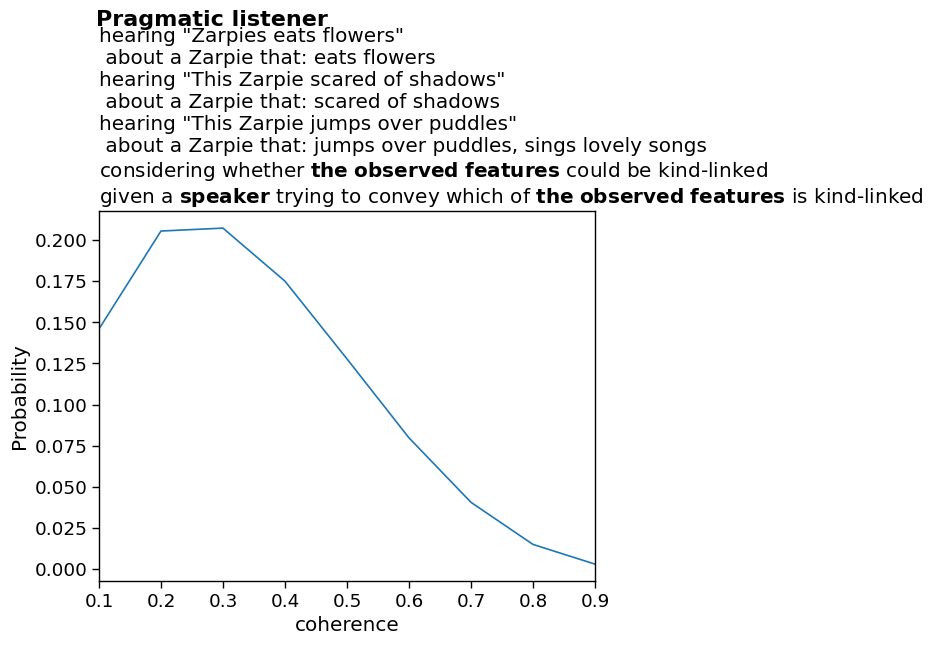

In [282]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Pragmatic listener",
             x = 0.12, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs/pragmatic_listener_multiple_2_coherence.png", bbox_inches = "tight")
plt.show(g)

* hearing enough specifics can actually outweigh a generic via coherence

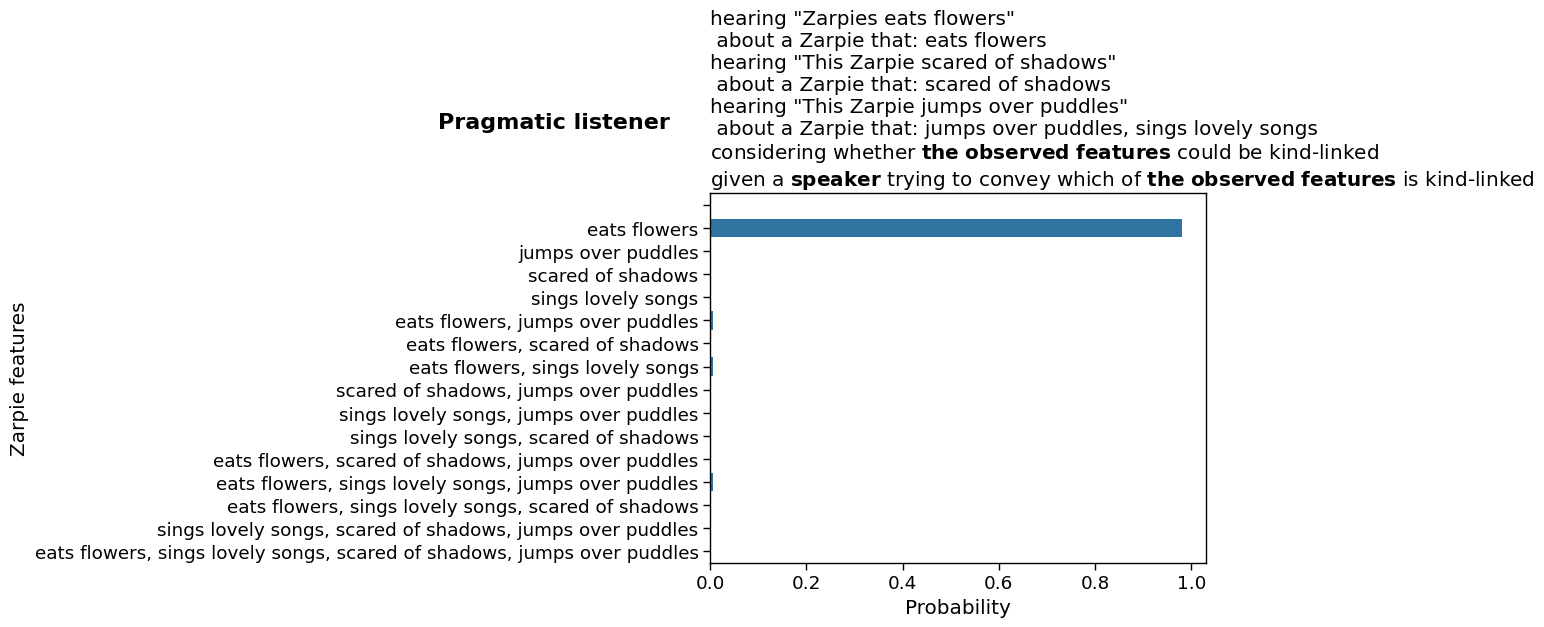

In [283]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Pragmatic listener",
             x = -0.3, y = 1.05,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs/pragmatic_listener_multiple_2_features.png", bbox_inches = "tight")
plt.show(g)

## Speaker 2

### Model predictions

In [57]:
# set up data
zarpies = Kind("Zarpies", ("eats flowers", "sings lovely songs", "jumps over puddles")) # Zarpies have these kind-linked features
example_zarpie = Instance("Zarpies", ("eats flowers", ))    # observe an instance of Zarpie that has these features

# run speaker model
speaker_dist = speaker2(kind_features = zarpies.features, 
                       observed_instance = example_zarpie)


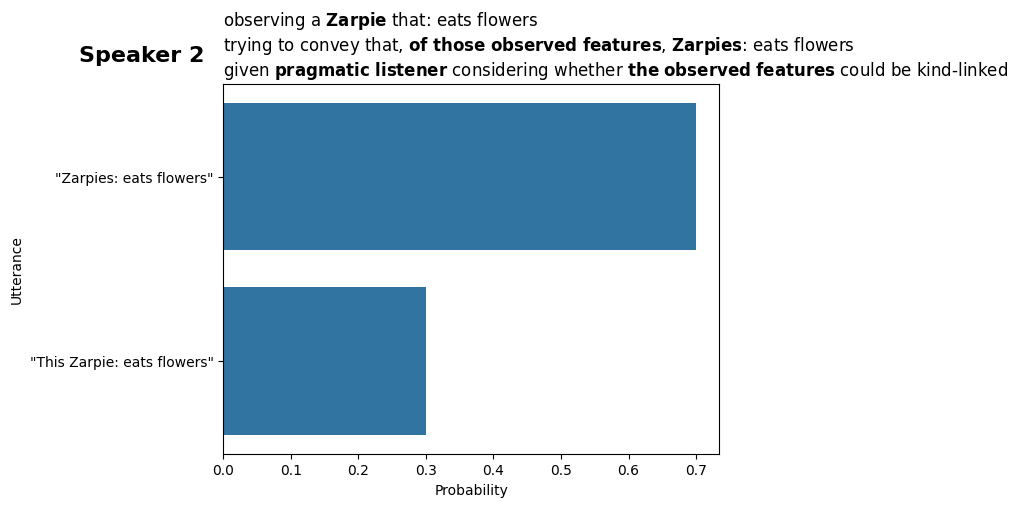

In [58]:
# convert to data frame
df_speaker_dist = dist_to_df(speaker_dist)
df_speaker_dist['Utterance'] = "\"" + df_speaker_dist['subj'] + ": " + df_speaker_dist['feature'] + "\""

# plot
g = sns.barplot(data = df_speaker_dist,
                 x = "Probability",
                 y = "Utterance")
plt.suptitle("Speaker 2",
             x = -0.1, y = 0.96,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title(r"observing a $\bf{Zarpie}$ that: " +
             ", ".join(example_zarpie.features) + "\n" +
             r"trying to convey that, $\bf{of}$ $\bf{those}$ $\bf{observed}$ $\bf{features}$, $\bf{Zarpies}$: " + 
             ", ".join(set(example_zarpie.features) & set(zarpies.features)) + "\n" +
             r"given $\bf{pragmatic}$ $\bf{listener}$ considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
             x = 0, y = 1,
             horizontalalignment = "left")

plt.savefig("figs/speaker2_1kindlinked.png", bbox_inches = "tight")
plt.show(g)

#### Generic exaggeration effect

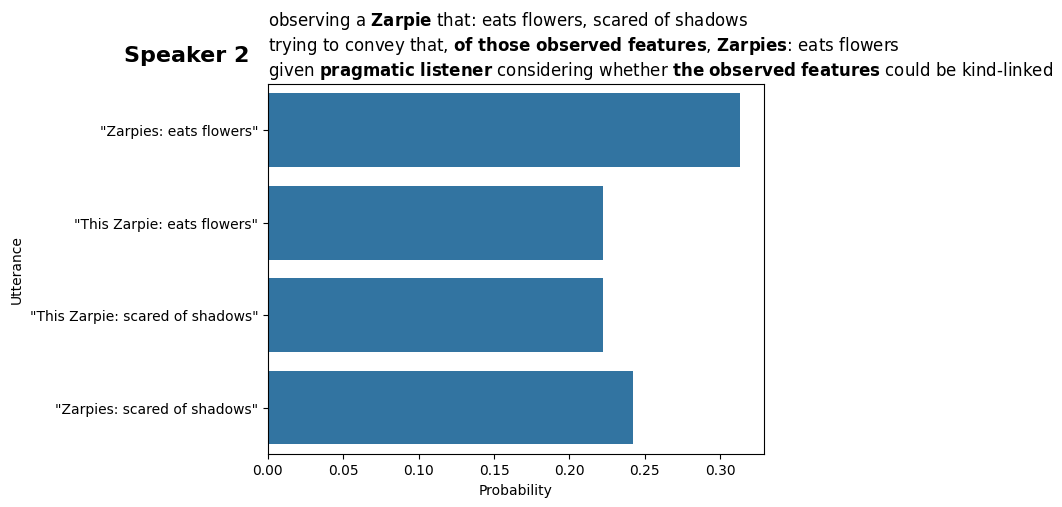

In [59]:
# set up data
zarpies = Kind("Zarpies", ("eats flowers", "sings lovely songs", "jumps over puddles")) # Zarpies have these kind-linked features
example_zarpie = Instance("Zarpies", ("eats flowers", "scared of shadows"))             # observe an instance of Zarpie that has these features

# run speaker model
speaker_dist = speaker2(kind_features = zarpies.features, 
                       observed_instance = example_zarpie)

# convert to data frame
df_speaker_dist = dist_to_df(speaker_dist)
df_speaker_dist['Utterance'] = "\"" + df_speaker_dist['subj'] + ": " + df_speaker_dist['feature'] + "\""

# plot
g = sns.barplot(data = df_speaker_dist,
                 x = "Probability",
                 y = "Utterance")
plt.suptitle("Speaker 2",
             x = -0.1, y = 0.96,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title(r"observing a $\bf{Zarpie}$ that: " +
             ", ".join(example_zarpie.features) + "\n" +
             r"trying to convey that, $\bf{of}$ $\bf{those}$ $\bf{observed}$ $\bf{features}$, $\bf{Zarpies}$: " + 
             ", ".join(set(example_zarpie.features) & set(zarpies.features)) + "\n" +
             r"given $\bf{pragmatic}$ $\bf{listener}$ considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
             x = 0, y = 1,
             horizontalalignment = "left")

plt.savefig("figs/speaker2_1kindlinked_1notkindlinked.png", bbox_inches = "tight")
plt.show(g)